# IWI Prediction using CLIP Embeddings
In this notebook, we'll use CLIP embeddings derived from satellite images to predict the `IWI` (International Wealth Index) of various locations.


In [2]:
import os
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, LeaveOneGroupOut, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM_STATE = 42

In [3]:
# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

embeddings = np.load(os.path.join(DATA_DIR, 'new_clip_embeddings.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_img_data.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
68070,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
68071,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
68072,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
68073,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


Rescale embeddings

In [4]:
embeddings_scaler = StandardScaler()
embeddings = embeddings_scaler.fit_transform(embeddings)

## Data exploration

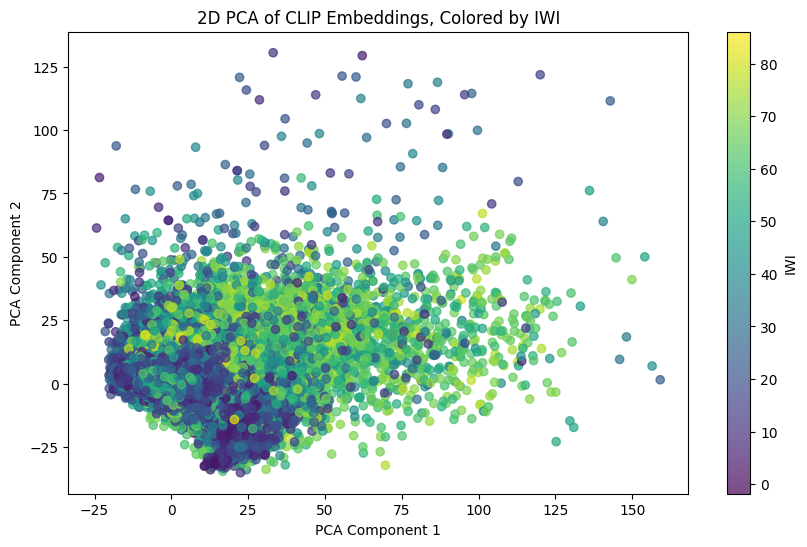

In [5]:
# Reduce the embeddings to 2 principal components for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Add PCA components to the DataFrame for easy plotting
df['embedding_pca1'] = embeddings_2d[:, 0]
df['embedding_pca2'] = embeddings_2d[:, 1]

# Plot the first two principal components of the embeddings, colored by IWI
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['embedding_pca1'], df['embedding_pca2'], c=df['iwi'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label="IWI")
plt.title("2D PCA of CLIP Embeddings, Colored by IWI")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

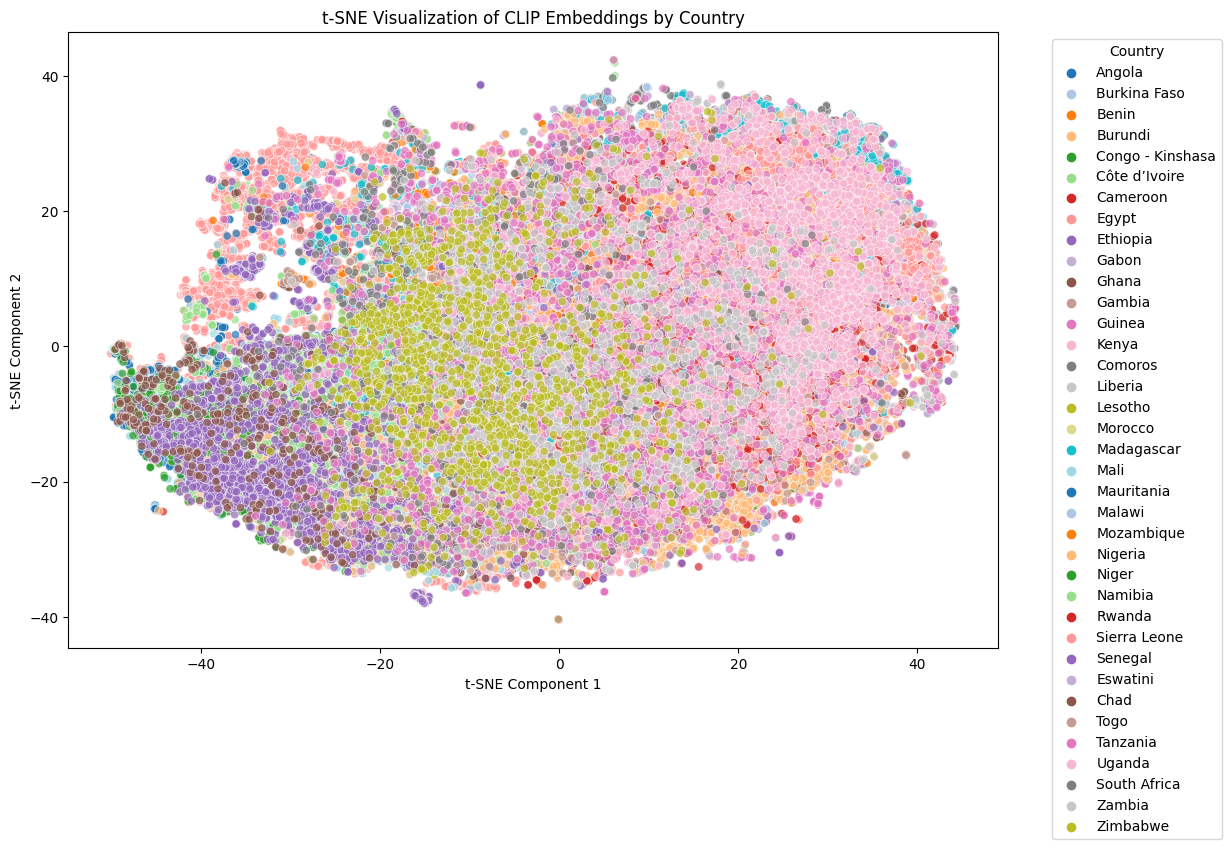

In [6]:
# T-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
embeddings_2d = tsne.fit_transform(embeddings)

df['embedding_tsne1'] = embeddings_2d[:, 0]
df['embedding_tsne2'] = embeddings_2d[:, 1]

# Plot the t-SNE embeddings, colored by country
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, x='embedding_tsne1', y='embedding_tsne2', 
    hue='country', palette='tab20', alpha=0.7
)
plt.title("t-SNE Visualization of CLIP Embeddings by Country")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


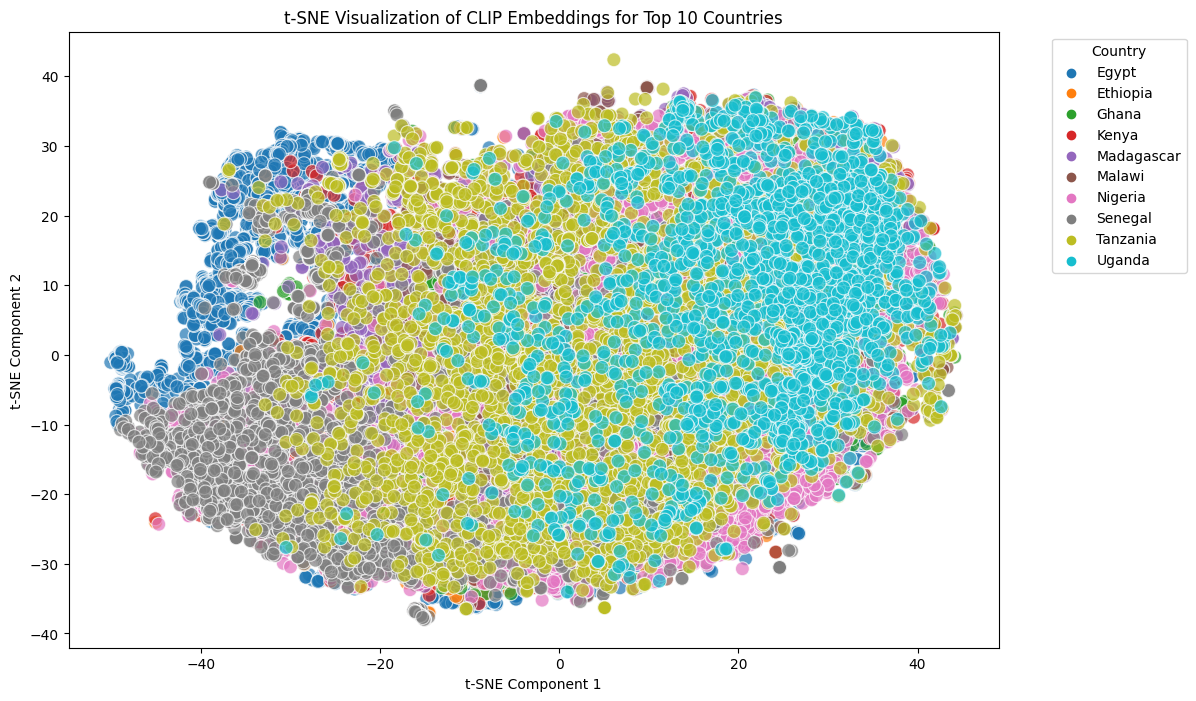

In [7]:
# Get only top 10 countries
top_countries = df['country'].value_counts().head(10).index
df_top_countries = df[df['country'].isin(top_countries)]

# Plot the t-SNE embeddings for just the top 10 countries
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_top_countries, x='embedding_tsne1', y='embedding_tsne2',
    hue='country', palette='tab10', alpha=0.7, s=100
)
plt.title("t-SNE Visualization of CLIP Embeddings for Top 10 Countries")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Feature selection

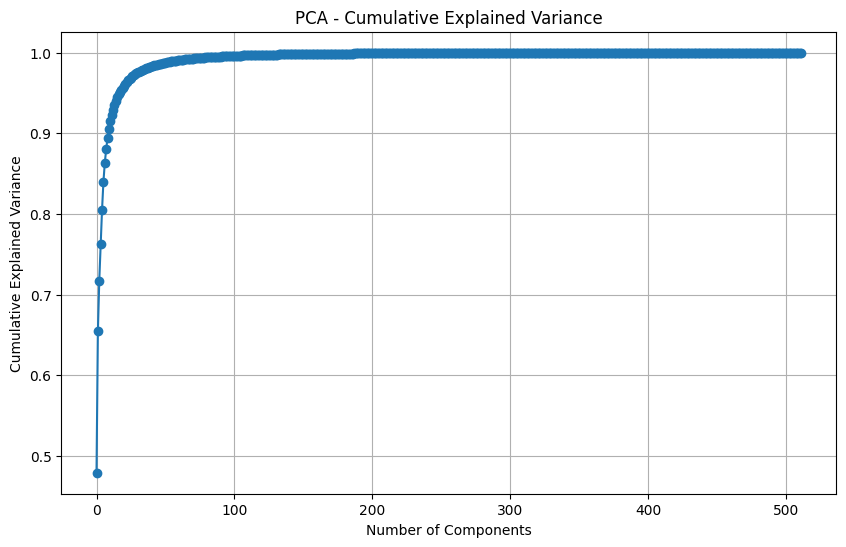

In [8]:
# Do full PCA
pca = PCA()
pca.fit(embeddings)

# Plot the cumulative explained variance to determine the optimal number of components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [11]:
# Choose the number of components required to capture 95% of the original variance
n_components = np.argmax(cumulative_variance > 0.99)
pca = PCA(n_components=n_components)
embeddings_reduced = pca.fit_transform(embeddings)

# 'embeddings_reduced' now contains the reduced feature set
print("Reduced embeddings shape:", embeddings_reduced.shape)

Reduced embeddings shape: (68075, 512)


## Train models

In [12]:
# Target variable: `IWI`
X = embeddings_reduced
y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
countries = df['country']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)
_, _, countries_train, countries_test = train_test_split(X, countries, test_size=.2, random_state=RANDOM_STATE)

Helper function to perform training, hyperparameter tuning, and evaluation

In [13]:
def train_and_evaluate(model, params, X_train, y_train, X_test, y_test, n_iter=10):
    # RandomSearchCV for cross-validation and hyperparameter tuning
    random_search = RandomizedSearchCV(
        model, params, n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE
    )
    random_search.fit(X_train, y_train)
    
    # Best estimator and cross-validated score
    best_model = random_search.best_estimator_
    print(f"Best parameters: {random_search.best_params_}")
    
    # Cross-validation score
    cv_score = -random_search.best_score_
    print(f"Cross-validated MSE: {cv_score:.4f}")
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R^2: {test_r2:.4f}\n")
    
    return best_model, test_mae, test_r2

Define the models and hyperparameters to test

In [14]:
models = {
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0.1, 0.5, 0.9, 0.99]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [10, 20, 30, -1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 6, 10]
        }
    },
    'MLP': {
        'model': MLPRegressor(max_iter=1000, random_state=RANDOM_STATE),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }
    }
}

In [15]:
results = {}

# Run training and evaluation for each model
for model_name, model_data in models.items():
    print(f"--- {model_name} ---")
    best_model, test_mae, test_r2 = train_and_evaluate(model_data['model'], model_data['params'], X_train, y_train, X_test, y_test)
    
    results[model_name] = {
        'best_model': best_model, 
        'test_mae': test_mae, 
        'test_r2': test_r2
    }

--- Lasso ---


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.314453125, tolerance: 0.19904939830303192
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'alpha': 0.001}
Cross-validated MSE: 0.0261
Test MSE: 0.0264
Test MAE: 0.1334
Test R^2: 0.2768

--- Ridge ---
Best parameters: {'alpha': 10}
Cross-validated MSE: 0.0235
Test MSE: 0.0236
Test MAE: 0.1244
Test R^2: 0.3522

--- ElasticNet ---


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.80252075195312, tolerance: 0.19904939830303192
  model = cd_fast.enet_coordinate_descent(


Best parameters: {'l1_ratio': 0.1, 'alpha': 0.001}
Cross-validated MSE: 0.0241
Test MSE: 0.0242
Test MAE: 0.1270
Test R^2: 0.3352

--- LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327094


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.76060485839844, tolerance: 0.15896134078502655
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.322660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327094


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.01733e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.82103e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.430167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326735


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.58795166015625, tolerance: 0.15908904373645782
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326145


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.85317611694336, tolerance: 0.15931464731693268
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327094


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.31142044067383, tolerance: 0.15896134078502655
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.464850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326459


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.59384e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.8031e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.83567428588867, tolerance: 0.15900273621082306
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.49991e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: I

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327014


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.4792251586914, tolerance: 0.15931464731693268
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.523423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.435786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326459


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.85562896728516, tolerance: 0.15908904373645782
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327094


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2213134765625, tolerance: 0.15982714295387268
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.83436e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.25153350830078, tolerance: 0.15900273621082306
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326735


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.423095703125, tolerance: 0.15982714295387268
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.419123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326459


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.304443359375, tolerance: 0.15900273621082306
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.83444e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.377004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326735


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24951171875, tolerance: 0.15931464731693268
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.51528e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326145


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.06061e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.81194e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.432281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327014


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2666015625, tolerance: 0.15908904373645782
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.45333e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 54460, number of used features: 512
[LightGBM] [Info] Start training from score 0.326690
Best parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.1}
Cross-validated MSE: 0.0212
Test MSE: 0.0211
Test MAE: 0.1151
Test R^2: 0.4217

--- XGBoost ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332184 seconds.
You can set `force_col_wise=true

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.351566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.327094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.465362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] 

## Results

In [16]:
results

{'Lasso': {'best_model': Lasso(alpha=0.001),
  'test_mae': 0.1334483332559204,
  'test_r2': 0.27681189588054356},
 'Ridge': {'best_model': Ridge(alpha=10),
  'test_mae': 0.12444012414825777,
  'test_r2': 0.3522178795288857},
 'ElasticNet': {'best_model': ElasticNet(alpha=0.001, l1_ratio=0.1),
  'test_mae': 0.1270149605207652,
  'test_r2': 0.3352024609699289},
 'LightGBM': {'best_model': LGBMRegressor(max_depth=20, n_estimators=200, random_state=42),
  'test_mae': 0.11511353223218342,
  'test_r2': 0.4216904735744875},
 'XGBoost': {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.312550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] Start training from score 0.326459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 43568, number of used features: 512
[LightGBM] [Info] 

In [9]:
results

{'Lasso': {'best_model': Lasso(alpha=0.001),
  'test_mae': 0.10999241064769029,
  'test_r2': 0.48095975378460976},
 'Ridge': {'best_model': Ridge(alpha=0.001),
  'test_mae': 0.10481424104580711,
  'test_r2': 0.5165845104994322},
 'ElasticNet': {'best_model': ElasticNet(alpha=0.001, l1_ratio=0.1),
  'test_mae': 0.1053333193178435,
  'test_r2': 0.5137442361177278},
 'LightGBM': {'best_model': LGBMRegressor(max_depth=20, n_estimators=200, random_state=42),
  'test_mae': 0.10009879816190913,
  'test_r2': 0.5549476753542053},
 'XGBoost': {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_st

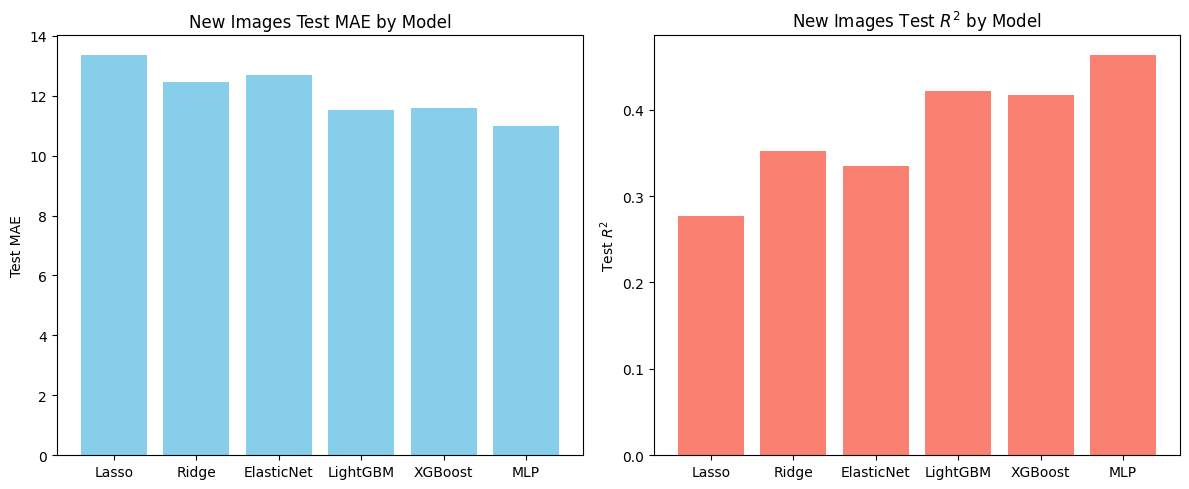

In [17]:
model_names = list(results.keys())
mae_scores = [100 * results[model]['test_mae'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [results[model]['test_r2'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("New Images Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"New Images Test $R^2$ by Model")

plt.tight_layout()
plt.show()

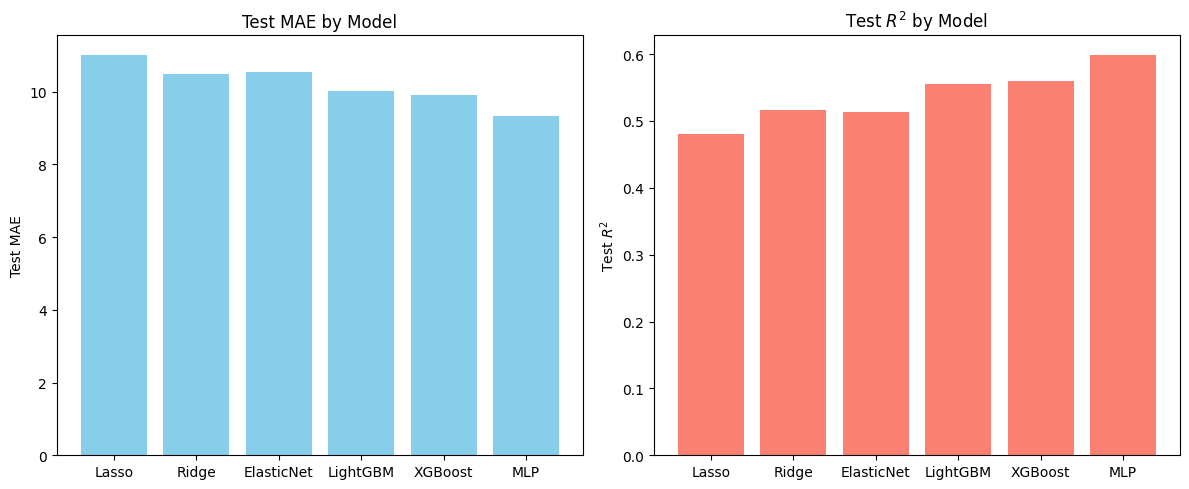

In [10]:
model_names = list(results.keys())
mae_scores = [100 * results[model]['test_mae'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [results[model]['test_r2'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by Model")

plt.tight_layout()
plt.show()

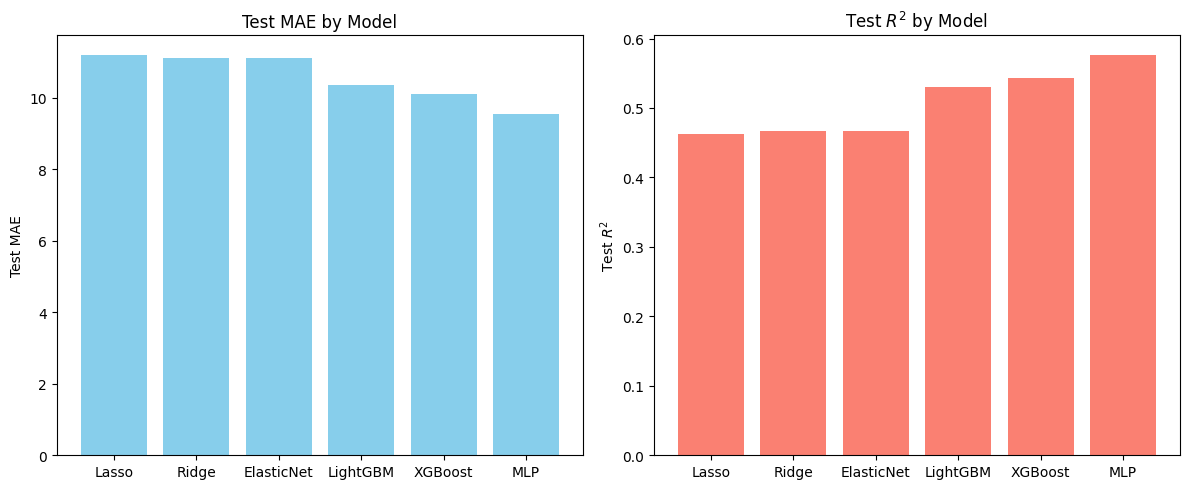

In [12]:
model_names = list(results.keys())
mae_scores = [100 * results[model]['test_mae'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [results[model]['test_r2'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by Model")

plt.tight_layout()
plt.show()

#### Plot results by country

In [18]:
from sklearn.model_selection import LeaveOneGroupOut

def evaluate_ooc(model, X, y, countries):
    
    logo = LeaveOneGroupOut()
    
    results = {}
    
    test_maes = []
    test_r2s = []

    for train_index, test_index in logo.split(X, y, countries):
        
        test_country = countries[test_index][0]
        X_test = X[test_index]
        y_test = y[test_index]
        
        y_pred = model.predict(X_test)
        country_mae = mean_absolute_error(y_test, y_pred)
        country_mse = mean_squared_error(y_test, y_pred)
        country_r2 = r2_score(y_test, y_pred)
        
        results[test_country] = {
            'test_mae': country_mae,
            'test_r2': country_r2
        }
        
        test_maes.append(country_mae)
        test_r2s.append(country_r2)
        
    mean_maes = np.mean(test_maes)
    mean_r2s = np.mean(test_r2s)
    
    results['mean_maes'] = mean_maes
    results['mean_r2s'] = mean_r2s
    
    print(f"Test MAE: {mean_maes:.4f}")
    print(f"Test R^2: {mean_r2s:.4f}\n")
    
    return results

In [19]:
ooc_results = {}

# Run training and evaluation for each model
for model_name, model_data in models.items():
    print(f"--- {model_name} ---")
    ooc_results[model_name] = evaluate_ooc(results[model_name]['best_model'], X_test, y_test, countries_test.values)

--- Lasso ---
Test MAE: 0.1366
Test R^2: -0.3215

--- Ridge ---
Test MAE: 0.1287
Test R^2: -0.2043

--- ElasticNet ---
Test MAE: 0.1307
Test R^2: -0.2213

--- LightGBM ---
Test MAE: 0.1197
Test R^2: -0.0678

--- XGBoost ---
Test MAE: 0.1200
Test R^2: -0.0689

--- MLP ---
Test MAE: 0.1158
Test R^2: -0.0137



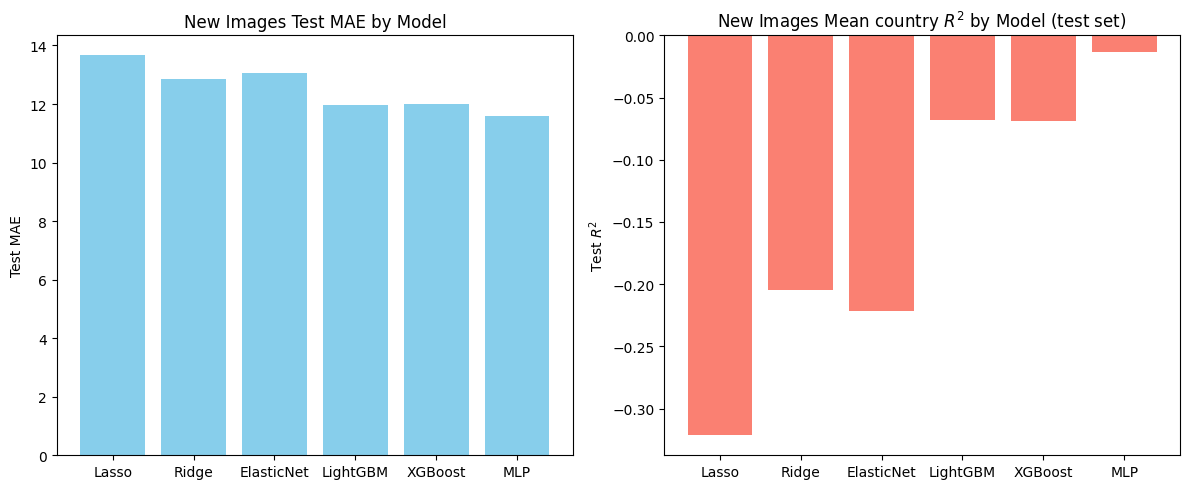

In [21]:
model_names = list(ooc_results.keys())
mae_scores = [100 * ooc_results[model]['mean_maes'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [ooc_results[model]['mean_r2s'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("New Images Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"New Images Mean country $R^2$ by Model (test set)")

plt.tight_layout()
plt.show()

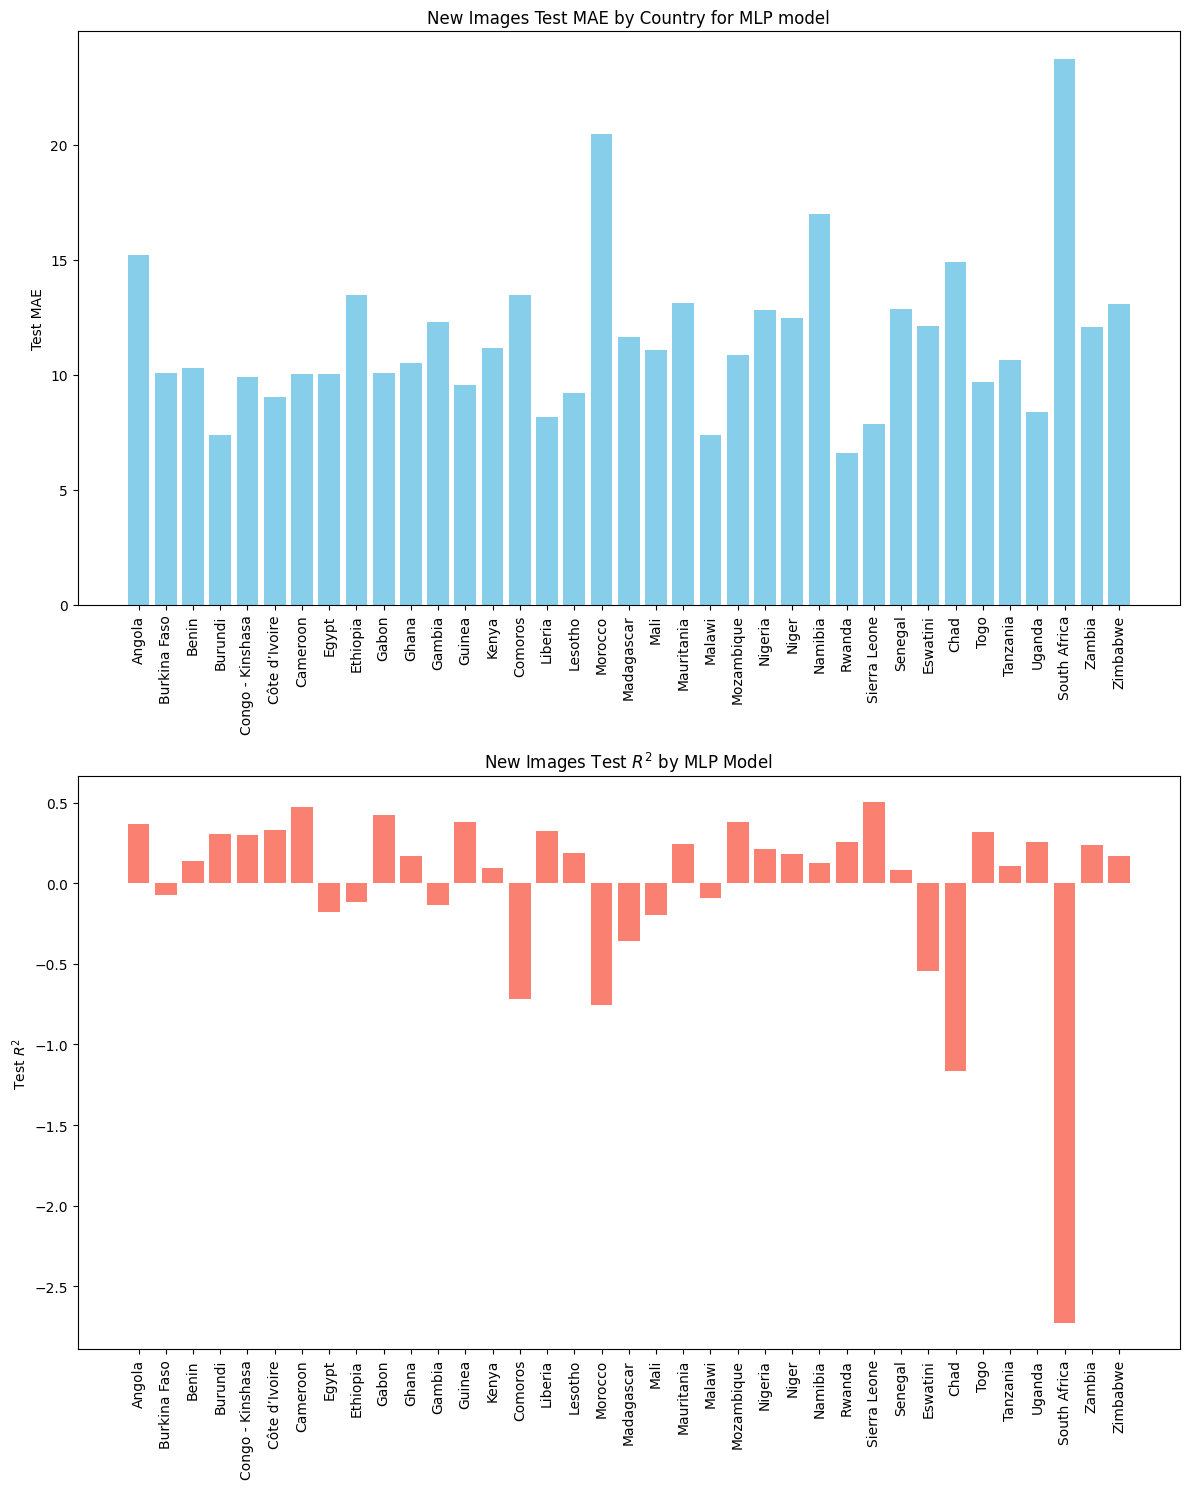

In [23]:
model_name = 'MLP'
mae_scores = []
r2_scores = []
country_names = countries.unique()

for country in country_names:
    mae_scores.append(ooc_results[model_name][country]['test_mae'] * 100)
    r2_scores.append(ooc_results[model_name][country]['test_r2'])
    
plt.figure(figsize=(12, 15))

# Plot MAE scores
plt.subplot(2, 1, 1)
plt.bar(country_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title(f"New Images Test MAE by Country for {model_name} model")
plt.xticks(rotation=90)

# Plot R^2 scores
plt.subplot(2, 1, 2)
plt.bar(country_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"New Images Test $R^2$ by " + model_name + " Model")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

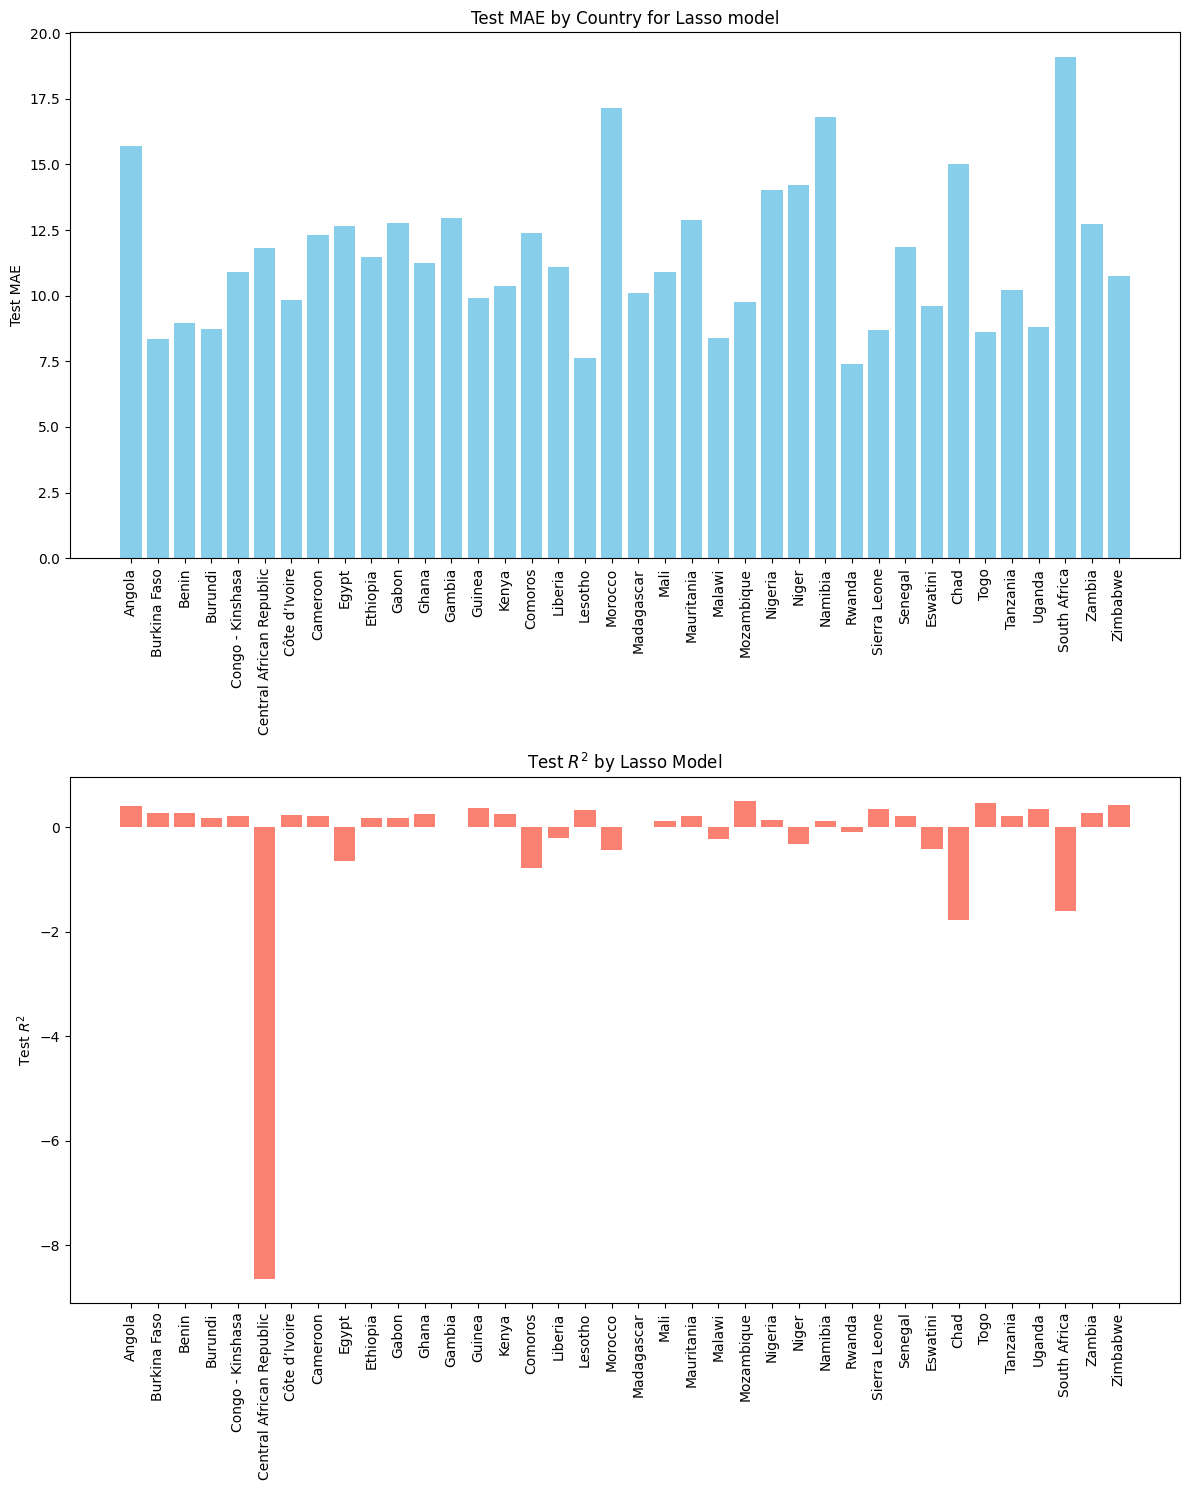

In [30]:
model_name = 'Lasso'
mae_scores = []
r2_scores = []
country_names = countries.unique()

for country in country_names:
    mae_scores.append(ooc_results[model_name][country]['test_mae'] * 100)
    r2_scores.append(ooc_results[model_name][country]['test_r2'])
    
plt.figure(figsize=(12, 15))

# Plot MAE scores
plt.subplot(2, 1, 1)
plt.bar(country_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title(f"Test MAE by Country for {model_name} model")
plt.xticks(rotation=90)

# Plot R^2 scores
plt.subplot(2, 1, 2)
plt.bar(country_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by " + model_name + " Model")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Train Out-of-country models

In [15]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.base import clone

def train_and_evaluate_ooc(model, X, y, countries):
    
    logo = LeaveOneGroupOut()
    
    results = {}
    
    test_maes = []
    test_r2s = []

    for train_index, test_index in logo.split(X, y, countries):
        
        test_country = countries[test_index].iloc[0]
        country_model = clone(model)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        country_model.fit(X_train, y_train)
        
        y_pred = country_model.predict(X_test)
        country_mae = mean_absolute_error(y_test, y_pred)
        country_mse = mean_squared_error(y_test, y_pred)
        country_r2 = r2_score(y_test, y_pred)
        
        results[test_country] = {
            'test_mae': country_mae,
            'test_r2': country_r2
        }
        
        test_maes.append(country_mae)
        test_r2s.append(country_r2)
        
    mean_maes = np.mean(test_maes)
    mean_r2s = np.mean(test_r2s)
    
    results['mean_maes'] = mean_maes
    results['mean_r2s'] = mean_r2s
    
    print(f"Test MAE: {mean_maes:.4f}")
    print(f"Test R^2: {mean_r2s:.4f}\n")
    
    return results

In [16]:
ooc_results = {}

# Run training and evaluation for each model
for model_name, model_data in models.items():
    print(f"--- {model_name} ---")
    ooc_results[model_name] = train_and_evaluate_ooc(results[model_name]['best_model'], X, y, countries)

--- Lasso ---
Test MAE: 0.1215
Test R^2: -0.1785

--- Ridge ---
Test MAE: 0.1211
Test R^2: -0.1765

--- ElasticNet ---
Test MAE: 0.1211
Test R^2: -0.1756

--- LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 68980, number of used features: 147
[LightGBM] [Info] Start training from score 0.324178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 68239, number of used features: 147
[LightGBM] [Info] Start training from score 0.325225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007912 seconds.
You can set `force_col_wise=true` to

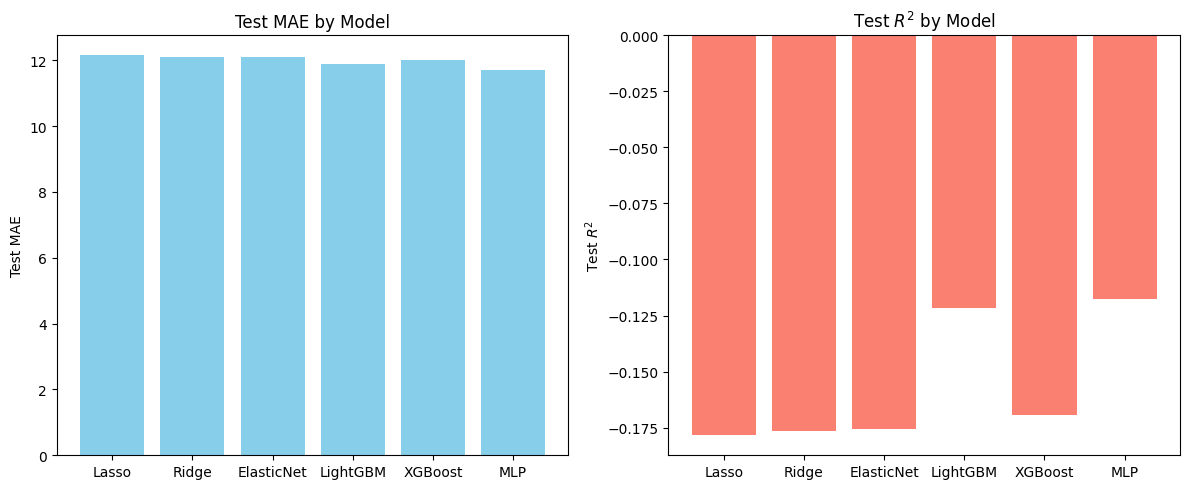

In [18]:
model_names = list(ooc_results.keys())
mae_scores = [100 * ooc_results[model]['mean_maes'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [ooc_results[model]['mean_r2s'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by Model")

plt.tight_layout()
plt.show()

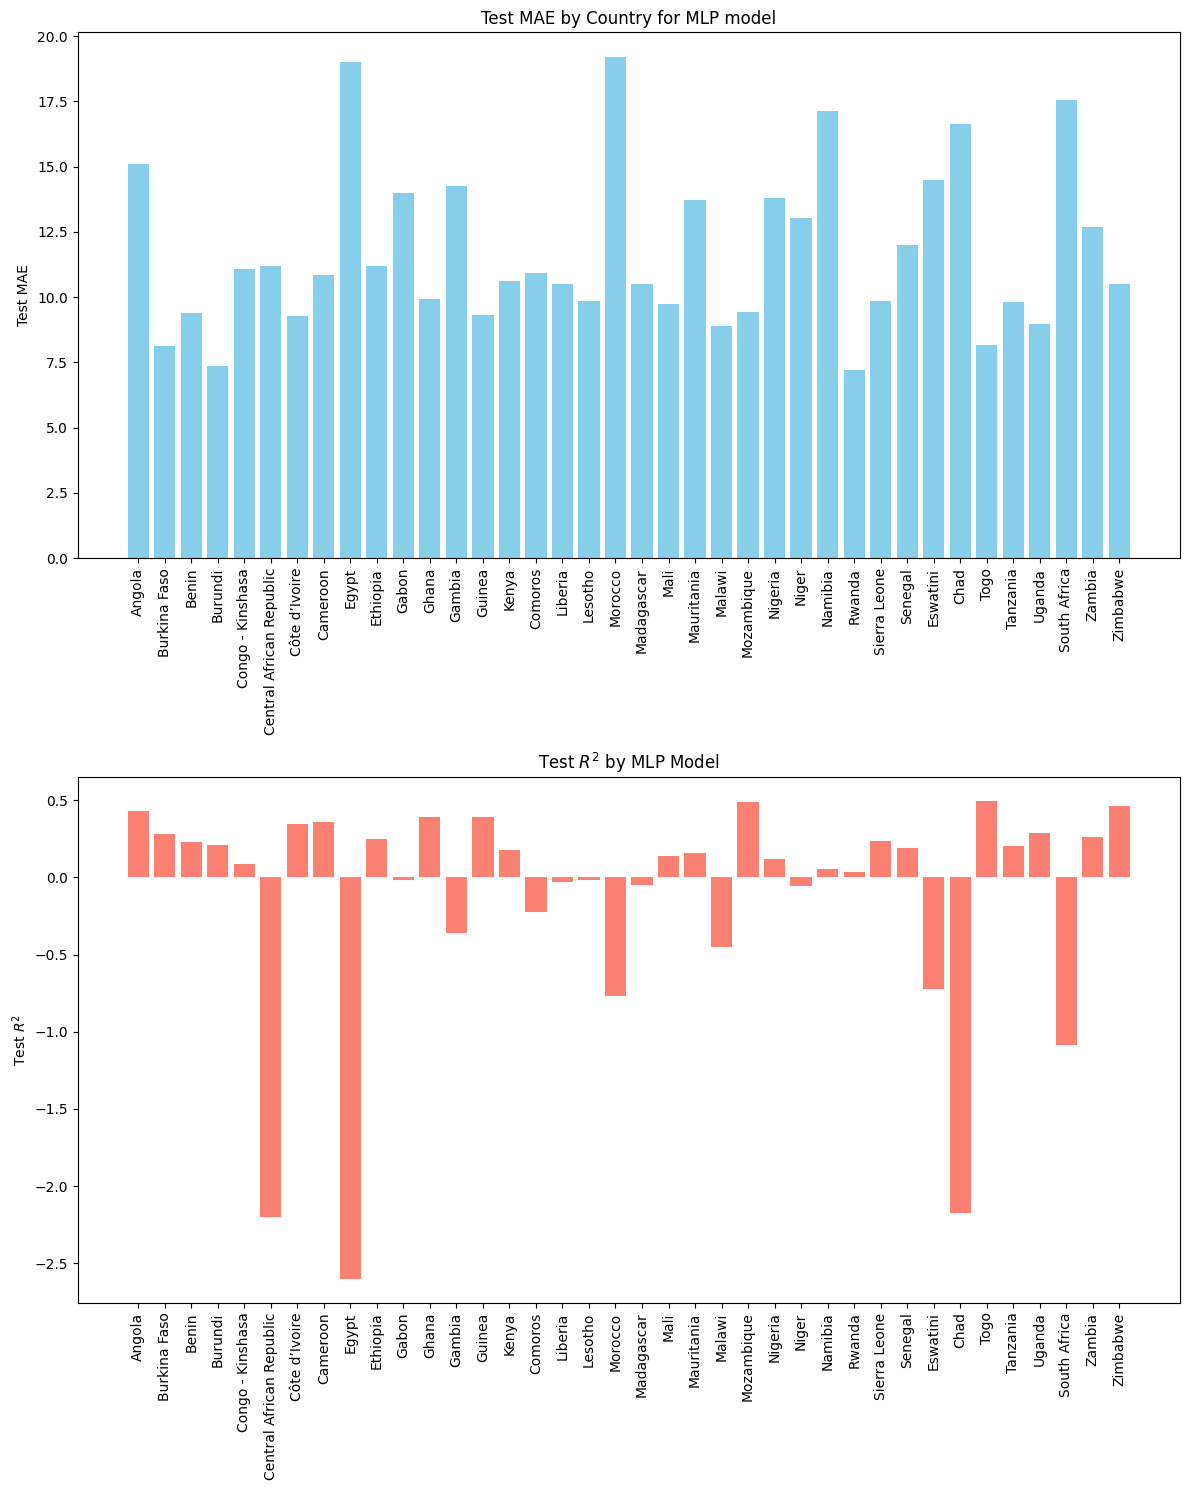

In [36]:
model_name = 'MLP'
mae_scores = []
r2_scores = []
country_names = countries.unique()

for country in country_names:
    mae_scores.append(ooc_results[model_name][country]['test_mae'] * 100)
    r2_scores.append(ooc_results[model_name][country]['test_r2'])
    
plt.figure(figsize=(12, 15))

# Plot MAE scores
plt.subplot(2, 1, 1)
plt.bar(country_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title(f"Test MAE by Country for {model_name} model")
plt.xticks(rotation=90)

# Plot R^2 scores
plt.subplot(2, 1, 2)
plt.bar(country_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by " + model_name + " Model")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Speed test

In [30]:
results

{'Lasso': {'best_model': Lasso(alpha=0.001),
  'test_mae': 0.11067981228057362,
  'test_r2': 0.466194254077652},
 'Ridge': {'best_model': Ridge(alpha=100),
  'test_mae': 0.10976077789914618,
  'test_r2': 0.47071530288543983},
 'ElasticNet': {'best_model': ElasticNet(alpha=0.001, l1_ratio=0.1),
  'test_mae': 0.10979868151457507,
  'test_r2': 0.4707562840417826},
 'LightGBM': {'best_model': LGBMRegressor(max_depth=20, n_estimators=200, random_state=42),
  'test_mae': 0.10287762751670929,
  'test_r2': 0.5279956798254968},
 'XGBoost': {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step

In [34]:
from time import time

for model_name in results:
    model = clone(results[model_name]['best_model'])
    t0 = time()
    model.fit(X_train, y_train)
    t1 = time()
    print(f'Training time for {model_name} is {(t1-t0):.2f} seconds')

Training time for Lasso is 0.06 seconds
Training time for Ridge is 0.04 seconds
Training time for ElasticNet is 0.06 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 55959, number of used features: 147
[LightGBM] [Info] Start training from score 0.324290
Training time for LightGBM is 0.88 seconds
Training time for XGBoost is 31.79 seconds
Training time for MLP is 2.96 seconds


In [33]:
0

0